# Split 7:3

In [98]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_squared_log_error
import itertools
import warnings
import numpy as np

In [99]:
df = pd.read_csv('SGT.csv')
df

,time,open,high,low,close,volume
0,3/1/2019,3980,3980,3960,3960,20
1,3/4/2019,3680,3960,3680,3720,400
2,3/5/2019,3930,3930,3930,3930,10
3,3/6/2019,3930,3930,3930,3930,150
4,3/7/2019,3790,3860,3790,3860,110
...,...,...,...,...,...,...
1317,6/7/2024,14800,14900,14600,14800,78100
1318,6/10/2024,14850,14850,14600,14600,39600
1319,6/11/2024,14550,14550,14000,14050,126200
1320,6/12/2024,14000,14200,13700,14200,83400


In [100]:

# Drop column that aren't use
df.drop(['open', 'high', 'low', 'volume'], axis = 1, inplace=True)

# Drop missing values
df = df.dropna()


In [101]:
df['time'] = pd.to_datetime(df['time'])

In [102]:
# Check if data still contain null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1322 entries, 0 to 1321
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    1322 non-null   datetime64[ns]
 1   close   1322 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 20.8 KB


In [103]:
df = df.set_index('time')

In [104]:
# Get the last date in the 'Date' column
last_date = df.index[-1]

# Create a new column with the next 30 days
next_30_days = pd.date_range(start=last_date + datetime.timedelta(days=1), periods=30)

# Create next 30 days dataframe
forecast_df = pd.DataFrame(index=next_30_days)
forecast_df.index.name = "time"

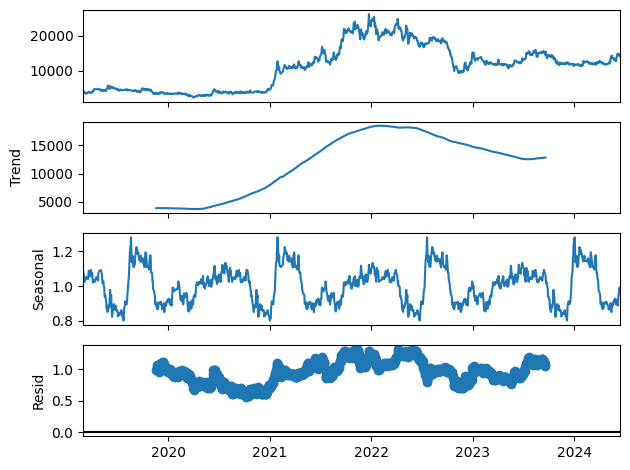

In [105]:
# Perform seasonal decomposition on the resampled dataframe using a multiplicative model and a period of  (day)
decompose = df
decompose_result = seasonal_decompose(decompose,model='mul', period=365)
decompose_result.plot();

In [106]:
# Calculate the accuracy of each model
def evaluateModel(test,pred):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_value = test.close.values
  pred_value = pred.values
  test_ape = np.abs((test_value - pred_value) / test_value)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)

  test_msle = mean_squared_log_error(test, pred)
  print('MSLE:', test_msle)

In [107]:
# 2. Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = len(df) - train_size

train = df[:train_size]
test = df[train_size:]

In [108]:
# Holt's Winter (Recommended, as the gold price should have trend and seasonal)
holt_winter = ExponentialSmoothing(train, trend="mul", seasonal="mul", seasonal_periods=249, damped_trend=True)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [109]:
# Fit Holt's Winter and get prediction
fit = holt_winter.fit(optimized=True)
pred = fit.forecast(len(test))

# Get prediction for 30 days
pred_30_days = fit.forecast(len(test) + len(forecast_df))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


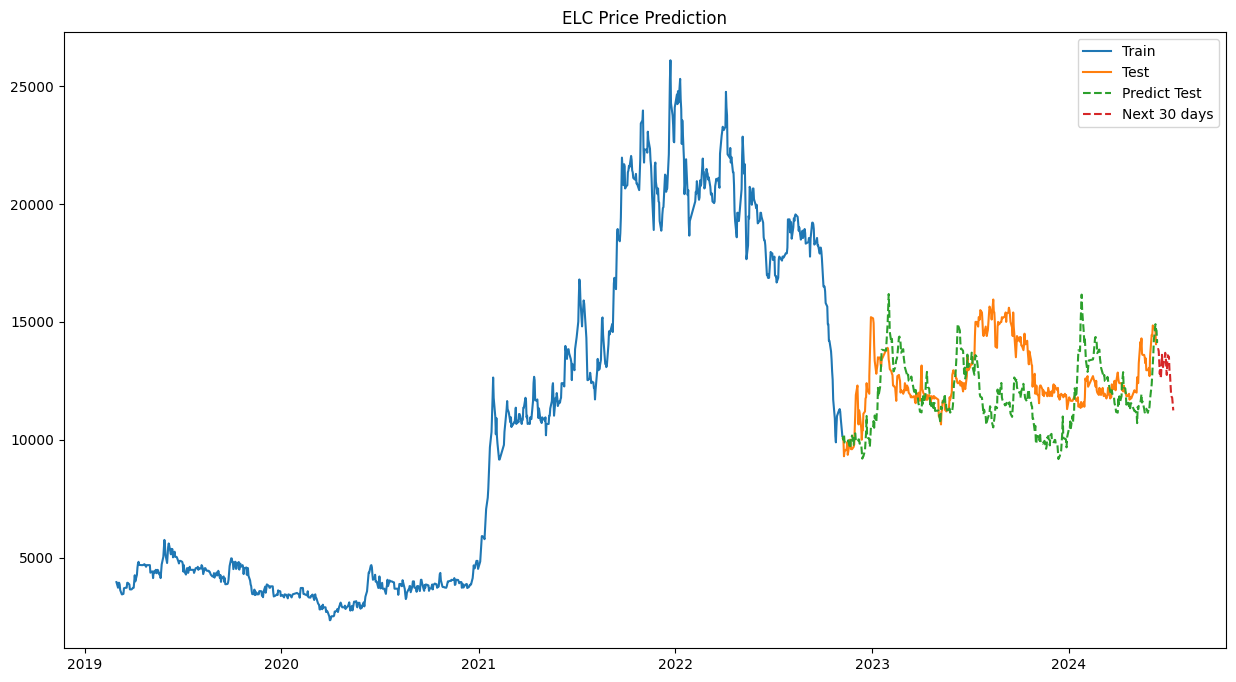

In [110]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(train.index, train['close'], label="Train");
ax.plot(test.index, test['close'], label='Test');
ax.plot(test.index, pred, linestyle='--', label="Predict Test");
ax.plot(forecast_df.index, pred_30_days.tail(30), linestyle='--', label="Next 30 days")
ax.legend();
ax.set_title("ELC Price Prediction");

In [111]:
evaluateModel(test, pred)

** Testing **
MAE:  1524.6818713587852
MAPE:  11.619418627245318
RMSE:  1916.4403731330187
MSLE: 0.02346308699402651


In [112]:
print(fit.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    close   No. Observations:                  925
Model:             ExponentialSmoothing   SSE                      168225958.027
Optimized:                         True   AIC                          11710.698
Trend:                   Multiplicative   BIC                          12937.466
Seasonal:                Multiplicative   AICC                         11907.680
Seasonal Periods:                   249   Date:                 Sun, 16 Jun 2024
Box-Cox:                          False   Time:                         10:52:08
Box-Cox Coeff.:                    None                                         
                           coeff                 code              optimized      
----------------------------------------------------------------------------------
smoothing_level                0.9950000                alpha                 True
smoothing_trend       

# Split 8:2

In [113]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_squared_log_error
import itertools
import warnings
import numpy as np

In [114]:
df = pd.read_csv('SGT.csv')
df

,time,open,high,low,close,volume
0,3/1/2019,3980,3980,3960,3960,20
1,3/4/2019,3680,3960,3680,3720,400
2,3/5/2019,3930,3930,3930,3930,10
3,3/6/2019,3930,3930,3930,3930,150
4,3/7/2019,3790,3860,3790,3860,110
...,...,...,...,...,...,...
1317,6/7/2024,14800,14900,14600,14800,78100
1318,6/10/2024,14850,14850,14600,14600,39600
1319,6/11/2024,14550,14550,14000,14050,126200
1320,6/12/2024,14000,14200,13700,14200,83400


In [115]:

# Drop column that aren't use
df.drop(['open', 'high', 'low', 'volume'], axis = 1, inplace=True)

# Drop missing values
df = df.dropna()


In [116]:
df['time'] = pd.to_datetime(df['time'])

In [117]:
# Check if data still contain null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1322 entries, 0 to 1321
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    1322 non-null   datetime64[ns]
 1   close   1322 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 20.8 KB


In [118]:
df = df.set_index('time')

In [119]:
# Get the last date in the 'Date' column
last_date = df.index[-1]

# Create a new column with the next 30 days
next_30_days = pd.date_range(start=last_date + datetime.timedelta(days=1), periods=30)

# Create next 30 days dataframe
forecast_df = pd.DataFrame(index=next_30_days)
forecast_df.index.name = "time"

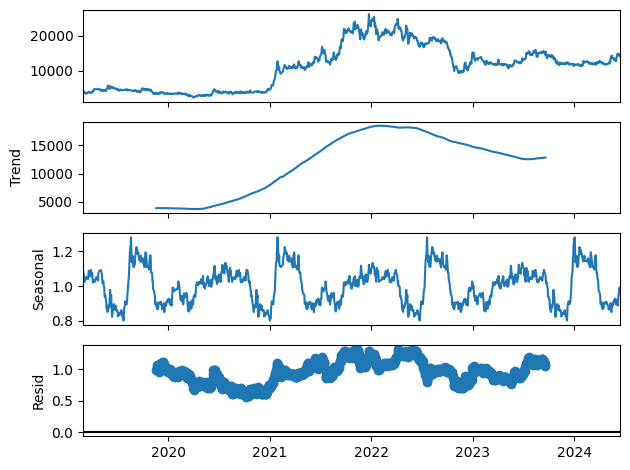

In [120]:
# Perform seasonal decomposition on the resampled dataframe using a multiplicative model and a period of  (day)
decompose = df
decompose_result = seasonal_decompose(decompose,model='mul', period=365)
decompose_result.plot();

In [121]:
# Calculate the accuracy of each model
def evaluateModel(test,pred):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_value = test.close.values
  pred_value = pred.values
  test_ape = np.abs((test_value - pred_value) / test_value)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)

  test_msle = mean_squared_log_error(test, pred)
  print('MSLE:', test_msle)

In [122]:
# 2. Split the data into training, testing, and validation sets
train_size = int(0.8 * len(df))
test_size = len(df) - train_size

train = df[:train_size]
test = df[train_size:]

In [123]:
# Holt's Winter (Recommended, as the gold price should have trend and seasonal)
holt_winter = ExponentialSmoothing(train, trend="mul", seasonal="mul", seasonal_periods=298, damped_trend=True)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [124]:
# Fit Holt's Winter and get prediction
fit = holt_winter.fit(optimized=True)
pred = fit.forecast(len(test))

# Get prediction for 30 days
pred_30_days = fit.forecast(len(test) + len(forecast_df))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


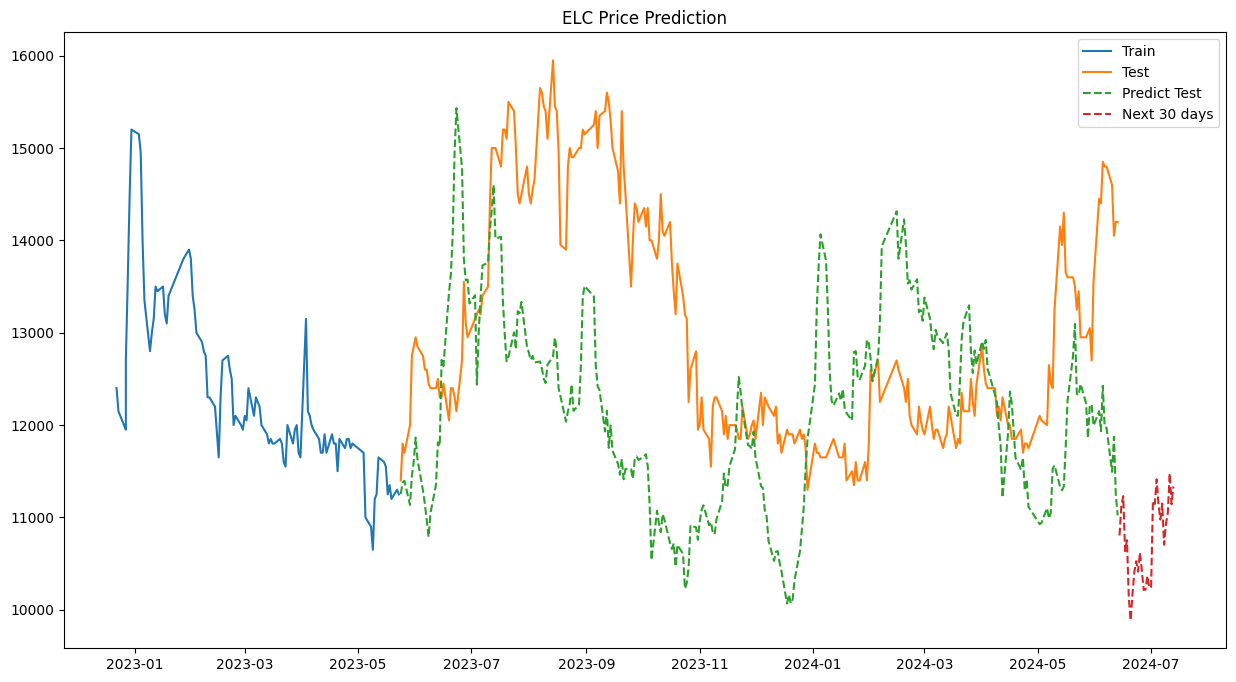

In [125]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(train.index[train_size - 100:], train['close'][train_size - 100:], label="Train");
ax.plot(test.index, test['close'], label='Test');
ax.plot(test.index, pred, linestyle='--', label="Predict Test");
ax.plot(forecast_df.index, pred_30_days.tail(30), linestyle='--', label="Next 30 days")
ax.legend();
ax.set_title("ELC Price Prediction");

In [126]:
evaluateModel(test, pred)

** Testing **
MAE:  1449.1117261979048
MAPE:  10.756870952615957
RMSE:  1755.4449291512858
MSLE: 0.01865871166282822


In [127]:
print(fit.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    close   No. Observations:                 1057
Model:             ExponentialSmoothing   SSE                      143147431.685
Optimized:                         True   AIC                          13095.719
Trend:                   Multiplicative   BIC                          14599.565
Seasonal:                Multiplicative   AICC                         13344.267
Seasonal Periods:                   298   Date:                 Sun, 16 Jun 2024
Box-Cox:                          False   Time:                         10:52:13
Box-Cox Coeff.:                    None                                         
                           coeff                 code              optimized      
----------------------------------------------------------------------------------
smoothing_level                0.9950000                alpha                 True
smoothing_trend       

# Split 9:1

In [128]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_squared_log_error
import itertools
import warnings
import numpy as np

In [129]:
df = pd.read_csv('SGT.csv')
df

,time,open,high,low,close,volume
0,3/1/2019,3980,3980,3960,3960,20
1,3/4/2019,3680,3960,3680,3720,400
2,3/5/2019,3930,3930,3930,3930,10
3,3/6/2019,3930,3930,3930,3930,150
4,3/7/2019,3790,3860,3790,3860,110
...,...,...,...,...,...,...
1317,6/7/2024,14800,14900,14600,14800,78100
1318,6/10/2024,14850,14850,14600,14600,39600
1319,6/11/2024,14550,14550,14000,14050,126200
1320,6/12/2024,14000,14200,13700,14200,83400


In [130]:

# Drop column that aren't use
df.drop(['open', 'high', 'low', 'volume'], axis = 1, inplace=True)

# Drop missing values
df = df.dropna()


In [131]:
df['time'] = pd.to_datetime(df['time'])

In [132]:
# Check if data still contain null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1322 entries, 0 to 1321
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    1322 non-null   datetime64[ns]
 1   close   1322 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 20.8 KB


In [133]:
df = df.set_index('time')

In [134]:
# Get the last date in the 'Date' column
last_date = df.index[-1]

# Create a new column with the next 30 days
next_30_days = pd.date_range(start=last_date + datetime.timedelta(days=1), periods=30)

# Create next 30 days dataframe
forecast_df = pd.DataFrame(index=next_30_days)
forecast_df.index.name = "time"

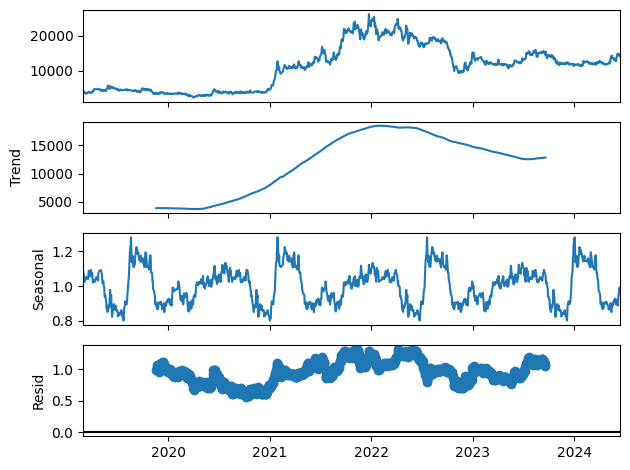

In [135]:
# Perform seasonal decomposition on the resampled dataframe using a multiplicative model and a period of  (day)
decompose = df
decompose_result = seasonal_decompose(decompose,model='mul', period=365)
decompose_result.plot();

In [136]:
# Calculate the accuracy of each model
def evaluateModel(test,pred):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_value = test.close.values
  pred_value = pred.values
  test_ape = np.abs((test_value - pred_value) / test_value)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)

  test_msle = mean_squared_log_error(test, pred)
  print('MSLE:', test_msle)

In [137]:
# 2. Split the data into training, testing, and validation sets
train_size = int(0.9 * len(df))
test_size = len(df) - train_size

train = df[:train_size]
test = df[train_size:]

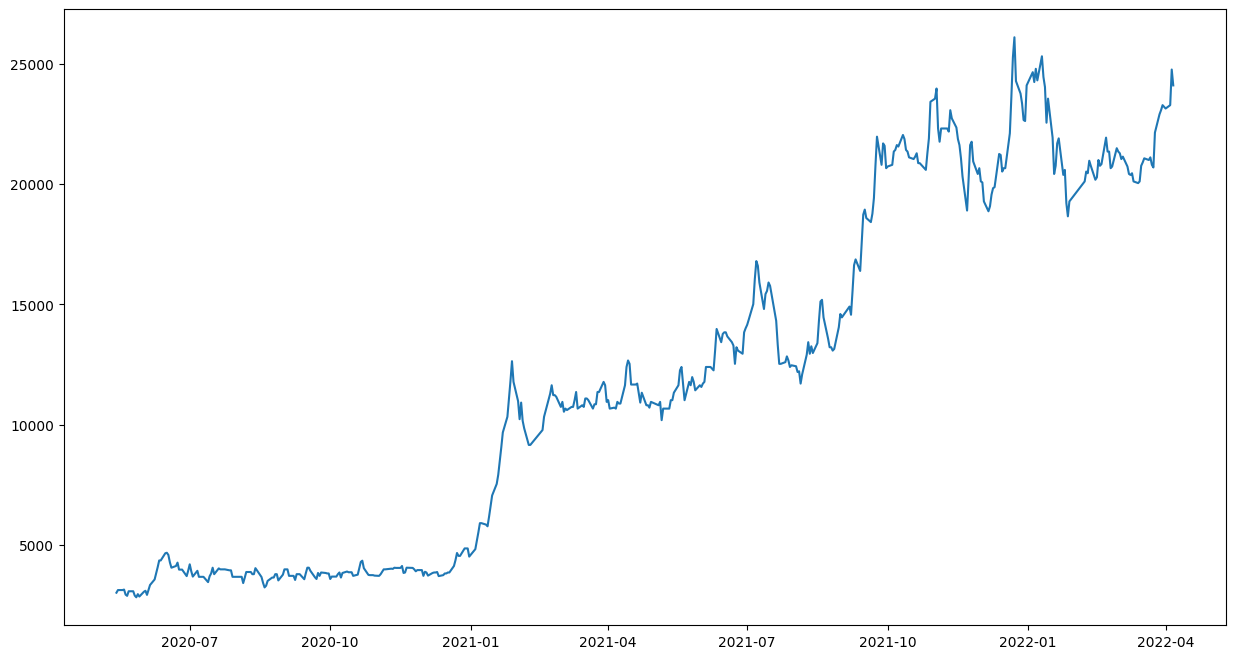

In [138]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(train.index[300:777], train['close'][300:777]);

In [139]:
# Holt's Winter (Recommended, as the gold price should have trend and seasonal)
holt_winter = ExponentialSmoothing(train, trend="mul", seasonal="mul", seasonal_periods=348, damped_trend=True)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [140]:
# Fit Holt's Winter and get prediction
fit = holt_winter.fit(optimized=True)
pred = fit.forecast(len(test))

# Get prediction for 30 days
pred_30_days = fit.forecast(len(test) + len(forecast_df))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


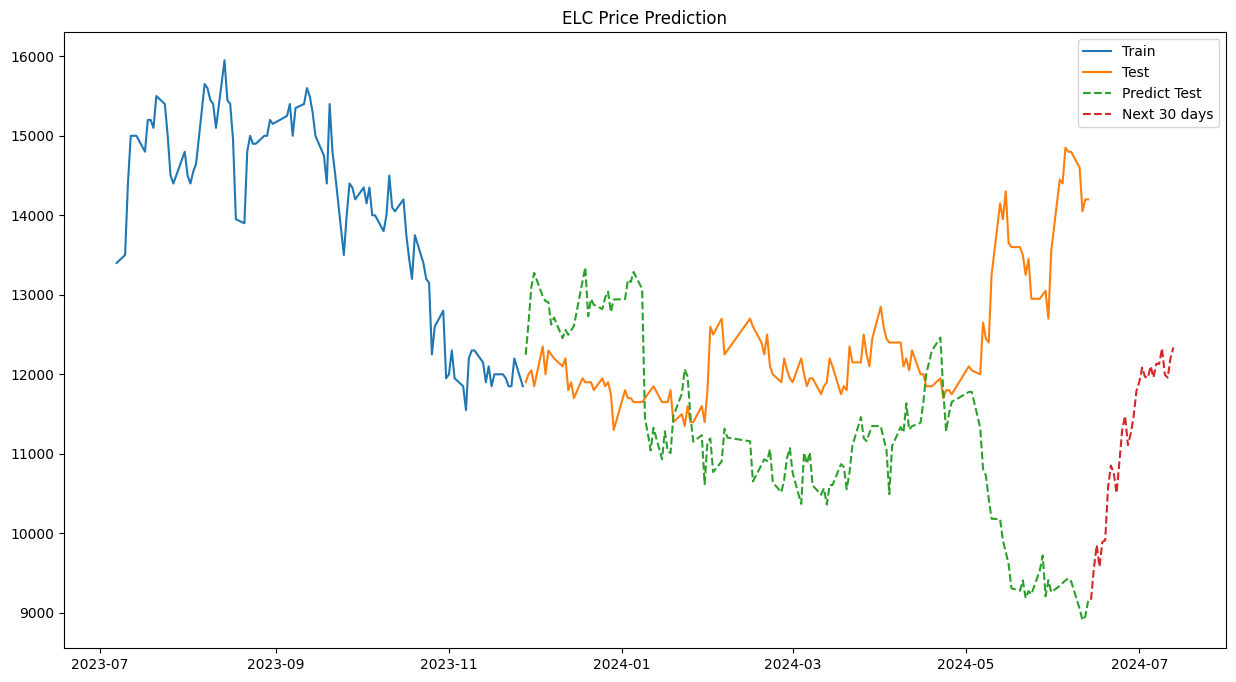

In [141]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(train.index[train_size - 100:], train['close'][train_size - 100:], label="Train");
ax.plot(test.index, test['close'], label='Test');
ax.plot(test.index, pred, linestyle='--', label="Predict Test");
ax.plot(forecast_df.index, pred_30_days.tail(30), linestyle='--', label="Next 30 days")
ax.legend();
ax.set_title("ELC Price Prediction");

In [142]:
evaluateModel(test, pred)

** Testing **
MAE:  1615.0564958792563
MAPE:  12.484850839796241
RMSE:  2165.2768887932775
MSLE: 0.03509565769529712


In [143]:
print(fit.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    close   No. Observations:                 1189
Model:             ExponentialSmoothing   SSE                      172514523.412
Optimized:                         True   AIC                          14837.413
Trend:                   Multiplicative   BIC                          16630.959
Seasonal:                Multiplicative   AICC                         15140.846
Seasonal Periods:                   348   Date:                 Sun, 16 Jun 2024
Box-Cox:                          False   Time:                         10:52:18
Box-Cox Coeff.:                    None                                         
                           coeff                 code              optimized      
----------------------------------------------------------------------------------
smoothing_level                0.9950000                alpha                 True
smoothing_trend       